# 고양이 수염 스티커 만들기

## 1. 이미지 데이터 준비

In [104]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print("🌫🛸")

🌫🛸


### 이미지 호출 및 크기 변경

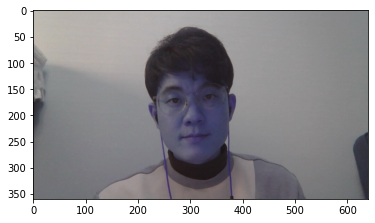

In [105]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image3.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

- opencv는 이미지 채널을 BGR(파랑, 녹색, 파랑)순으로 사용하기 때문에 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력

### 색깔 보정처리

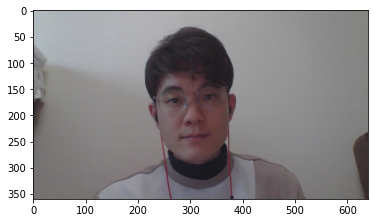

In [106]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. 얼굴 검출 및 랜드마크 검출하기

### 얼굴의 바운딩 박스(bounding box) 위치 찾기

#### hog detector 선언

In [107]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


#### detector를 이용한 얼굴 bouding box 추출

In [108]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


#### 찾은 얼굴 화면 출력

rectangles[[(218, 133) (373, 288)]]


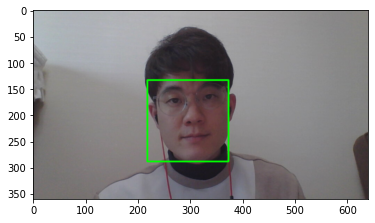

In [109]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 얼굴의 랜드마크(landmark) 위치 찾기

#### Landmark 모델 호출

In [110]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


#### landmark 생성

In [111]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


#### landmark를 이미지 상에 출력

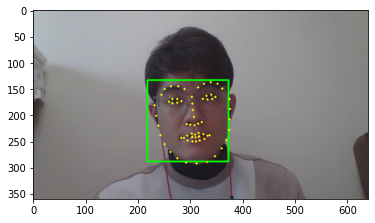

In [112]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 스티커 적용 위치 확인

### 코의 중심점 위치 확인

In [113]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # nose center index : 33
    x = landmark[33][0]
    y = landmark[33][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))


(308, 219)
(x,y) : (308,219)
(w,h) : (156,156)


- 이미지의 왼쪽 상단이 좌표계의 (0, 0)
- 고양이 수염은 코 위에 위치하여야 함으로 x, y 좌표는 landmark 인덱스 중 코 끝인 33번의 좌표 그대로 적용
- 이때 바운딩 박스는 정사각형(156X156)

## 4. 고양이 수염 스티커 적용

### 스티커 이미지  resize 및 확인

(156, 156, 3)


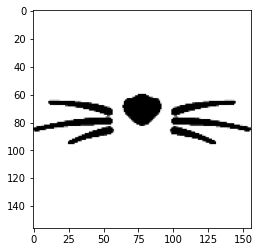

In [114]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show
print (img_sticker.shape)

- 스티커 이미지를 얼굴 바운딩박스 크기랑 동일하게 resize

### 스티커 이미지 좌표 조정

In [115]:
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (230,141)


In [116]:
# img_sticker = img_sticker[-refined_y:]
# print (img_sticker.shape)

# refined_y = 0
# print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 고양이 수염 스티커의 경우 Bounding box 안에 위치하게 되므로 
# 원본 사진 외부에 걸리지 않기 때문에 Crop할 필요가 없다

### 원본 이미지에 스티커 적용

In [117]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

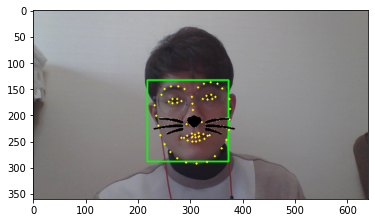

In [118]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [119]:
# sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
#     np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
# plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
# plt.show()

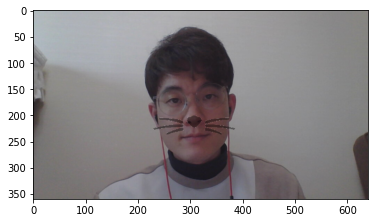

In [120]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.6, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.4, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 5.  문제점 찾아보기

### (1) 다양한 시도

#### 1. 얼굴의 각도가 정면이 아닌 경우

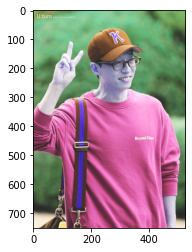

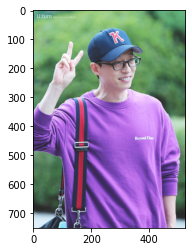

rectangles[[(239, 139) (368, 268)]]


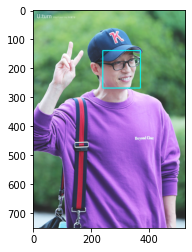

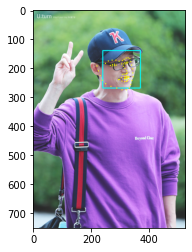

(318, 220)
(x,y) : (318,220)
(w,h) : (130,130)
(130, 130, 3)
(x,y) : (253,155)


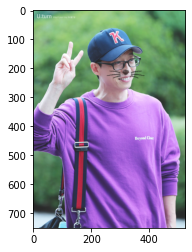

In [121]:
# 이미지 로드
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/you2.jpg'
img_bgr = cv2.imread(my_image_path)  
img_bgr = cv2.resize(img_bgr, dsize=(0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

# RGB 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# HOG Detector 선언
detector_hog = dlib.get_frontal_face_detector()

# Bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)

# 찾은 얼굴 영역 좌표
print(dlib_rects)
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (255,255,0), 2, lineType=cv2.LINE_AA)
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# landmark model 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) 
    x = landmark[33][0]
    y = landmark[33][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    
# 스티커 이미지 Read
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show
print (img_sticker.shape)

# 스티커 이미지 좌표
refined_x = x - w // 2  
refined_y = y - h // 2 
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 원본에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

#### 2. 이미지가 흑백인 경우

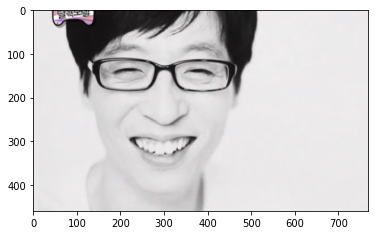

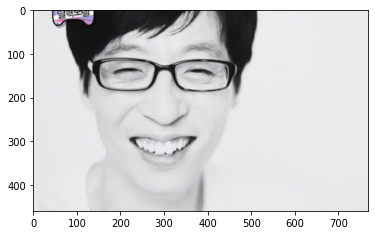

rectangles[[(134, 63) (455, 384)]]


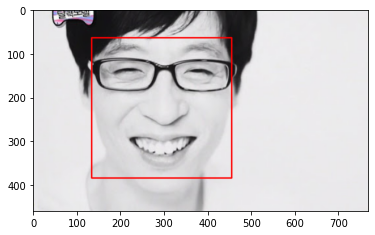

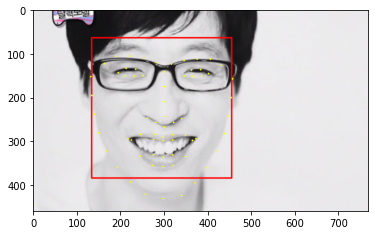

(303, 243)
(x,y) : (303,243)
(w,h) : (322,322)
(322, 322, 3)
(x,y) : (142,82)


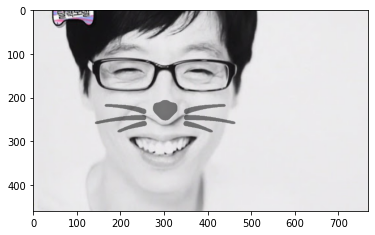

In [122]:
# 이미지 로드
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/you.jpg'
img_bgr = cv2.imread(my_image_path)  
img_bgr = cv2.resize(img_bgr, dsize=(0, 0), fx=1.5, fy=1.5, interpolation=cv2.INTER_AREA)
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

# RGB 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# HOG Detector 선언
detector_hog = dlib.get_frontal_face_detector()

# Bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)

# 찾은 얼굴 영역 좌표
print(dlib_rects)
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,0,255), 2, lineType=cv2.LINE_AA)
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# landmark model 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) 
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    
# 스티커 이미지 Read
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show
print (img_sticker.shape)

# 스티커 이미지 좌표
refined_x = x - w // 2  
refined_y = y - h // 2 
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 원본에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

#### 3. 얼굴이 2개 이상일 경우

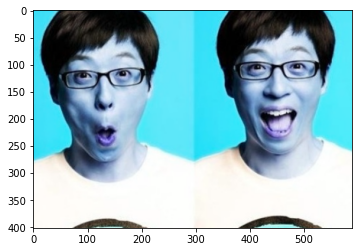

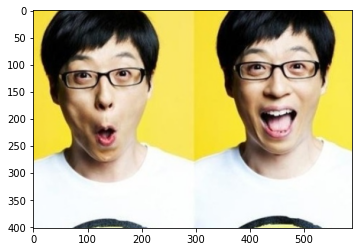

rectangles[[(369, 66) (529, 227)], [(48, 84) (208, 245)]]


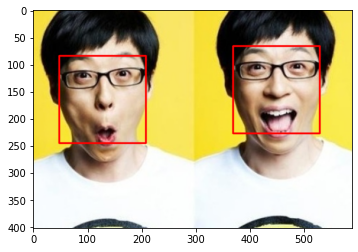

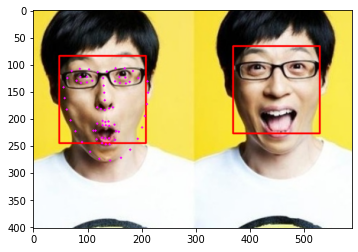

2
(452, 164)
(x,y) : (452,164)
(w,h) : (161,161)
(132, 184)
(x,y) : (132,184)
(w,h) : (161,161)
(161, 161, 3)
(x,y) : (52,104)


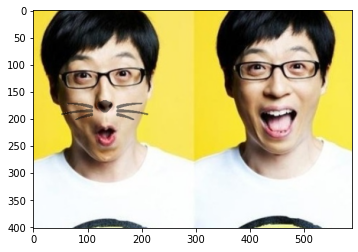

In [123]:
# 이미지 로드
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/you3.jpg'
img_bgr = cv2.imread(my_image_path)  
img_bgr = cv2.resize(img_bgr, dsize=(0, 0), fx=1.2, fy=1.2, interpolation=cv2.INTER_AREA)
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

# RGB 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# HOG Detector 선언
detector_hog = dlib.get_frontal_face_detector()

# Bounding box 추출
dlib_rects = detector_hog(img_rgb, 2)

# 찾은 얼굴 영역 좌표
print(dlib_rects)
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,0,255), 2, lineType=cv2.LINE_AA)
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# landmark model 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (255, 0, 255), -1)
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

print(len(list_landmarks))

# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) 
    x = landmark[33][0]
    y = landmark[33][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    
# 스티커 이미지 Read
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show
print (img_sticker.shape)

# 스티커 이미지 좌표
refined_x = x - w // 2  
refined_y = y - h // 2 
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 원본에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### (2) 문제점 도출

- 얼굴의 각도에 따라 고양이 수염 스티커는 각도가 변하지 않기 때문에 어색하다.
- 얼굴의 회전 각도가 클 경우 얼굴을 인식하지 못 한다.
- 멀리서 촬영했을 경우 얼굴을 인식하지 못하거나 다른 위치에 인식된다.
- 얼굴이 두 개 이상일 경우 face detection는 적용됐으나 face landmark는 1개만 생성이 되었다.
- 만약 개인정보, 초상권 등 공공을 위한 목적으로 사용되는 앱이라면 실행 속도는 사람이 인식할 수 없을만큼 빨라지고 정확한 위치를 인식해야 할 것이다.

---

## 루브릭 평가

#### 1. 자기만의 카메라앱 기능 구현을 완수하였다.  
    : face detection과 face landmark가 정상적으로 이루어졌으며, 고양이 수염 스티커 역시 위치하고자 했던 코 위에 정확히 반영됐다.  
    
#### 2. 스티커 이미지를 정확한 원본 위치에 반영하였다.  
    : 위치시키고자 헀던 face landmark 33번 인덱스 위에 위치시켰다.  
    
#### 3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.  
    : 얼굴 각도가 변형된 이미지, 멀리서 찍은 이미지, 흑백 이미지, 얼굴이 2개 이상인 이미지 등의 원본 이미지를 적용해 보았으며 그에 다른 문제점을 찾을 수 있었다.

---

## 회고

#### 1 프로젝트 진행시 어려웠던 점
    : 고양이 수염을 원하는 곳에 위치시키기 위해 좌표를 변환하는 방법이 잘 이해가 되지 않아 한참 고민했다. 머리 속으로만 생각하거나 계산하다가 직접 그려서 계산해보니 이해하기가 한결 수월해졌다.
    
#### 2. 프로젝트를 진행하면서 알아낸 점 또는 아직 모호한 점
    : 알아낸 점
        - cv2.resize로 x, y의 비율을 이용해 이미지의 크기를 변경하는 방법
        - cv2.addWeighted를 이용해 이미지를 중첩 또는 불투명하게 하는 방법
    : 아직 모호한 점
        - 얼굴 회전 및 각도에 자연스럽게 스티커 또한 회전 시키는 방법
    
#### 3.  루브릭 평가 지표를 맞추기 위해 시도한 점
    : 얼굴 각도가 변형된 이미지, 멀리서 찍은 이미지, 흑백 이미지, 얼굴이 2개 이상인 이미지 등의 다양한 원본 이미지를 적용해 보았다.
    
#### 4. 루브릭 평가 지표를 달성하지 못한 이유
    : 루브릭 평가에 대한 기본적인 사항을 달성했다고 생각되나 스티커가 자연스럽게 위치하게 하는 방법을 찾지 못했다.
    
#### 5.  프로젝트 진행 후 느낀 점 및 다짐
    : 노드 진행시 수월하게 진행되어 금방 끝낼 줄 알았었는데...정말 많은 시간이 걸렸다. 덕분에 계속 신경이 쓰여 이도저도 못했다. 대신 한 번 시도할 때 마다 새로운 방법을 알고 조금씩 해결해 나갈 수 있었다. 